## **SETUP**

In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
import os
scaler_input = StandardScaler()
scaler_output = StandardScaler()

# **LOADING DATA**

In [3]:

SteadyState_Input = []

base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\SteadyCSV'

transient_base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\ML_OuputMaxV_CSV'

Transient_Output = []

for i in range(1, 41):  # Loop from N1 to N40
    # Construct the steady state file path
    steady_folder_name = f"N{i}Steady"
    steady_file_name = f"N{i}SPVS.csv"
    steady_file_path = os.path.join(base_path, steady_folder_name, steady_file_name)
    
    # Construct the transient file path (assuming a similar naming convention)
    transient_folder_name = f"N{i}"
    transient_file_name = f"N{i}TPV.csv"
    transient_file_path = os.path.join(transient_base_path, transient_folder_name, transient_file_name)

      
    NP = pd.read_csv(steady_file_path)
    NP = NP.replace(' null', 0)
    NPSteady_velocity = NP.iloc[:, 4].values.reshape(-1, 1)
    NPSteady_velocity = scaler_input.fit_transform(NPSteady_velocity)
    SteadyState_Input.append(NPSteady_velocity)

    # Process the transient CSV
    NT = pd.read_csv(transient_file_path)
    NT = NT.replace(' null', 0)
    NPTransient_velocity = NT.iloc[:, 4].values.reshape(-1, 1)
    NPTransient_velocity = scaler_output.fit_transform(NPTransient_velocity)
    Transient_Output.append(NPTransient_velocity)


# **DENSE**

In [4]:
from keras.optimizers import Adam
# Preprocess the data
SteadyState_Input_Dense = np.concatenate(SteadyState_Input)
Transient_Output_Dense = np.concatenate(Transient_Output)

# Split the data into training and testing sets
Steady_train, Steady_test, Transient_train, Transient_test = train_test_split(SteadyState_Input_Dense, Transient_Output_Dense, test_size=0.2, random_state=42)

# Determine the number of input features
num_input_features = Steady_train.shape[1]

# Initialize the model
model = Sequential()

# Add input layer with neurons equal to the number of input features
model.add(Dense(num_input_features, input_dim=num_input_features, activation='relu'))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Determine the number of outputs and add output layer
num_outputs = Transient_train.shape[1] if len(Transient_train.shape) > 1 else 1
model.add(Dense(num_outputs))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mse'])

# Fit the model
model.fit(Steady_train, Transient_train, epochs=5, batch_size=16, validation_split=0.4)

# Evaluate the model
loss, mse = model.evaluate(Steady_test, Transient_test)
print(f"Model performance:\nLoss: {loss}\nMSE: {mse}")

Epoch 1/5
5334/5334 [==============================] - 8s 1ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 2/5
5334/5334 [==============================] - 7s 1ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0709 - val_mse: 0.0709
Epoch 3/5
5334/5334 [==============================] - 7s 1ms/step - loss: 0.0719 - mse: 0.0719 - val_loss: 0.0708 - val_mse: 0.0708
Epoch 4/5
5334/5334 [==============================] - 7s 1ms/step - loss: 0.0717 - mse: 0.0717 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 5/5
1112/1112 [==============================] - 1s 667us/step - loss: 0.0711 - mse: 0.0711
Model performance:
Loss: 0.07108455896377563
MSE: 0.07108455896377563


# **PREDICTION**

In [ ]:
base_path = r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions'
file_indices = [0, 41, 42, 43, 44, 45, 46, 47, 48, 49]
prediction_dir = os.path.join(base_path, 'PredictionFile')

# Ensure the directory exists
if not os.path.exists(prediction_dir):
    os.makedirs(prediction_dir)

# List to store predictions
predictions = []

# Loop through the files to read, preprocess, and predict
for i in file_indices:
    file_name = f"{base_path}\\N{i}\\N{i}SPVS.csv"
    data = pd.read_csv(file_name).replace(' null', 0)
    velocity = data.iloc[:, 4].values.reshape(-1, 1)
    velocity = scaler_input.transform(velocity)
    velocity = velocity.reshape((velocity.shape[0], 1, velocity.shape[1]))
    prediction = model.predict(velocity)
    prediction = scaler_output.inverse_transform(prediction)
    data[f'Transient Prediction {i}'] = prediction
    predictions.append(data)

# Save Predictions
for idx, prediction in zip(file_indices, predictions):
    prediction_file_name = f"{prediction_dir}\\N{idx}D.csv"
    prediction.to_csv(prediction_file_name, index=False)

# Printing Predictions (first 10 rows for brevity)
for idx, prediction in zip(file_indices, predictions):
    print(f"Prediction for N{idx}:\n", prediction.head(10))

In [32]:
# https://keras.io/api/models/model_training_apis/
SteadyState_New0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0\N0SPVS.csv')
SteadyState_New1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41\N41SPVS.csv')
SteadyState_New2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42\N42SPVS.csv')
SteadyState_New3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43\N43SPVS.csv')
SteadyState_New4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44\N44SPVS.csv')
SteadyState_New5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45\N45SPVS.csv')
SteadyState_New6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46\N46SPVS.csv')
SteadyState_New7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47\N47SPVS.csv')
SteadyState_New8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48\N48SPVS.csv')
SteadyState_New9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49\N49SPVS.csv')
SteadyState_New0 = SteadyState_New0.replace(' null', 0)
SteadyState_New1 = SteadyState_New1.replace(' null', 0)
SteadyState_New2 = SteadyState_New2.replace(' null', 0)
SteadyState_New3 = SteadyState_New3.replace(' null', 0)
SteadyState_New4 = SteadyState_New4.replace(' null', 0)
SteadyState_New5 = SteadyState_New5.replace(' null', 0)
SteadyState_New6 = SteadyState_New6.replace(' null', 0)
SteadyState_New7 = SteadyState_New7.replace(' null', 0)
SteadyState_New8 = SteadyState_New8.replace(' null', 0)
SteadyState_New9 = SteadyState_New9.replace(' null', 0)
SteadyStateVelocity_0 = SteadyState_New0.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_1 = SteadyState_New1.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_2 = SteadyState_New2.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_3 = SteadyState_New3.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_4 = SteadyState_New4.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_5 = SteadyState_New5.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_6 = SteadyState_New6.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_7 = SteadyState_New7.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_8 = SteadyState_New8.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_9 = SteadyState_New9.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_0 = scaler_input.transform(SteadyStateVelocity_0 )
SteadyStateVelocity_1 = scaler_input.transform(SteadyStateVelocity_1 )
SteadyStateVelocity_2 = scaler_input.transform(SteadyStateVelocity_2 )
SteadyStateVelocity_3 = scaler_input.transform(SteadyStateVelocity_3 )
SteadyStateVelocity_4 = scaler_input.transform(SteadyStateVelocity_4 )
SteadyStateVelocity_5 = scaler_input.transform(SteadyStateVelocity_5 )
SteadyStateVelocity_6 = scaler_input.transform(SteadyStateVelocity_6 )
SteadyStateVelocity_7 = scaler_input.transform(SteadyStateVelocity_7 )
SteadyStateVelocity_8 = scaler_input.transform(SteadyStateVelocity_8 )
SteadyStateVelocity_9 = scaler_input.transform(SteadyStateVelocity_9 )
SteadyStateVelocity_0 = SteadyStateVelocity_0.reshape((SteadyStateVelocity_0.shape[0], 1, SteadyStateVelocity_0.shape[1]))
SteadyStateVelocity_1 = SteadyStateVelocity_1.reshape((SteadyStateVelocity_1.shape[0], 1, SteadyStateVelocity_1.shape[1]))
SteadyStateVelocity_2 = SteadyStateVelocity_2.reshape((SteadyStateVelocity_2.shape[0], 1, SteadyStateVelocity_2.shape[1]))
SteadyStateVelocity_3 = SteadyStateVelocity_3.reshape((SteadyStateVelocity_3.shape[0], 1, SteadyStateVelocity_3.shape[1]))
SteadyStateVelocity_4 = SteadyStateVelocity_4.reshape((SteadyStateVelocity_4.shape[0], 1, SteadyStateVelocity_4.shape[1]))
SteadyStateVelocity_5 = SteadyStateVelocity_5.reshape((SteadyStateVelocity_5.shape[0], 1, SteadyStateVelocity_5.shape[1]))
SteadyStateVelocity_6 = SteadyStateVelocity_6.reshape((SteadyStateVelocity_6.shape[0], 1, SteadyStateVelocity_6.shape[1]))
SteadyStateVelocity_7 = SteadyStateVelocity_7.reshape((SteadyStateVelocity_7.shape[0], 1, SteadyStateVelocity_7.shape[1]))
SteadyStateVelocity_8 = SteadyStateVelocity_8.reshape((SteadyStateVelocity_8.shape[0], 1, SteadyStateVelocity_8.shape[1]))
SteadyStateVelocity_9 = SteadyStateVelocity_9.reshape((SteadyStateVelocity_9.shape[0], 1, SteadyStateVelocity_9.shape[1]))
Prediction0 = model.predict(SteadyStateVelocity_0)
Prediction1 = model.predict(SteadyStateVelocity_1)
Prediction2 = model.predict(SteadyStateVelocity_2)
Prediction3 = model.predict(SteadyStateVelocity_3)
Prediction4 = model.predict(SteadyStateVelocity_4)
Prediction5 = model.predict(SteadyStateVelocity_5)
Prediction6 = model.predict(SteadyStateVelocity_6)
Prediction7 = model.predict(SteadyStateVelocity_7)
Prediction8 = model.predict(SteadyStateVelocity_8)
Prediction9 = model.predict(SteadyStateVelocity_9)
Prediction0 = scaler_output.inverse_transform(Prediction0)
Prediction1 = scaler_output.inverse_transform(Prediction1)
Prediction2 = scaler_output.inverse_transform(Prediction2)
Prediction3 = scaler_output.inverse_transform(Prediction3)
Prediction4 = scaler_output.inverse_transform(Prediction4)
Prediction5 = scaler_output.inverse_transform(Prediction5)
Prediction6 = scaler_output.inverse_transform(Prediction6)
Prediction7 = scaler_output.inverse_transform(Prediction7)
Prediction8 = scaler_output.inverse_transform(Prediction8)
Prediction9 = scaler_output.inverse_transform(Prediction9)
SteadyState_New0 ['Transient Prediction 0'] = Prediction0
SteadyState_New1 ['Transient Prediction 1'] = Prediction1
SteadyState_New2 ['Transient Prediction 2'] = Prediction2
SteadyState_New3 ['Transient Prediction 3'] = Prediction3
SteadyState_New4 ['Transient Prediction 4'] = Prediction4
SteadyState_New5 ['Transient Prediction 5'] = Prediction5
SteadyState_New6 ['Transient Prediction 6'] = Prediction6
SteadyState_New7 ['Transient Prediction 7'] = Prediction7
SteadyState_New8 ['Transient Prediction 8'] = Prediction8
SteadyState_New9 ['Transient Prediction 9'] = Prediction9
print(Prediction0)
print(Prediction1)
print(Prediction2)
print(Prediction3)
print(Prediction4)
print(Prediction5)
print(Prediction6)
print(Prediction7)
print(Prediction8)
print(Prediction9)
SteadyState_New0.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0D.csv', index=False)
SteadyState_New1.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41D.csv', index=False)
SteadyState_New2.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42D.csv', index=False)
SteadyState_New3.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43D.csv', index=False)
SteadyState_New4.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44D.csv', index=False)
SteadyState_New5.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45D.csv', index=False)
SteadyState_New6.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46D.csv', index=False)
SteadyState_New7.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47D.csv', index=False)
SteadyState_New8.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48D.csv', index=False)
SteadyState_New9.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49D.csv', index=False)

62/62 [==============================] - 0s 757us/step
[[0.47708976]
 [0.48190802]
 [0.47548363]
 ...
 [0.30494422]
 [0.2572485 ]
 [0.21180122]]
[[0.64736986]
 [0.48190802]
 [0.50405097]
 ...
 [0.20271178]
 [0.11104311]
 [0.02503021]]
[[0.50405097]
 [0.50405097]
 [0.50557566]
 ...
 [0.02503021]
 [0.02503021]
 [0.02503021]]
[[0.5696118 ]
 [0.56351304]
 [0.48993847]
 ...
 [0.02503021]
 [0.02503021]
 [0.02503021]]
[[0.5711364 ]
 [0.5604637 ]
 [0.5741857 ]
 ...
 [0.02503021]
 [0.02503021]
 [0.14458442]]
[[0.44175568]
 [0.4513923 ]
 [0.27542737]
 ...
 [0.09283159]
 [0.06551827]
 [0.02503021]]
[[0.48030192]
 [0.446574  ]
 [0.48993847]
 ...
 [0.14733739]
 [0.22634433]
 [0.25906634]]
[[0.5909571 ]
 [0.6062038 ]
 [0.59553117]
 ...
 [0.08427218]
 [0.05771409]
 [0.02503021]]
[[0.42087653]
 [0.42730087]
 [0.53149503]
 ...
 [0.28440478]
 [0.27724525]
 [0.27906314]]
[[0.6229752 ]
 [0.6244998 ]
 [0.66871524]
 ...
 [0.3582389 ]
 [0.34378406]
 [0.36145106]]


# **RESULTS N0**

In [33]:
PredictedTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0D.csv')
# Print column names
print(PredictedTransient0.columns)
PredictedTransient0 = PredictedTransient0.fillna(0)
PredictedTransient0 = PredictedTransient0.replace(' null', np.nan)
x = PredictedTransient0[' X [ m ]']
z = PredictedTransient0[' Z [ m ]']
ste_velocity = PredictedTransient0[' Velocity [ m s^-1 ]']
velocity = PredictedTransient0['Transient Prediction 0']
diff_ste = PredictedTransient0['Transient Prediction 0'] - PredictedTransient0[' Velocity [ m s^-1 ]']
CFDTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0TMAX\N0TV.csv')
print(CFDTransient0.columns)
CFDTransient0 = CFDTransient0.fillna(0)
CFDTransient0 = CFDTransient0.replace(' null', np.nan)
x = CFDTransient0 [' X [ m ]']
z = CFDTransient0 [' Z [ m ]']
velocity_truth = CFDTransient0 [' Velocity [ m s^-1 ]']
diff_vel = PredictedTransient0['Transient Prediction 0'] - CFDTransient0[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 0'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


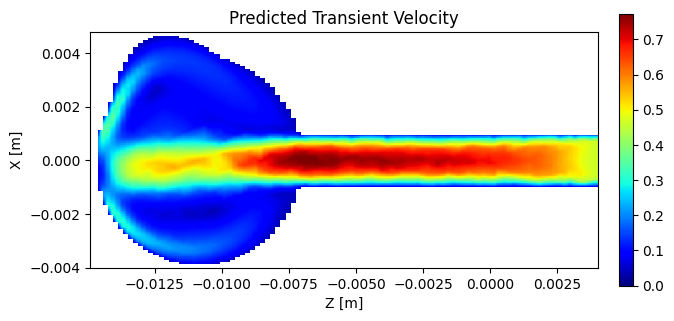

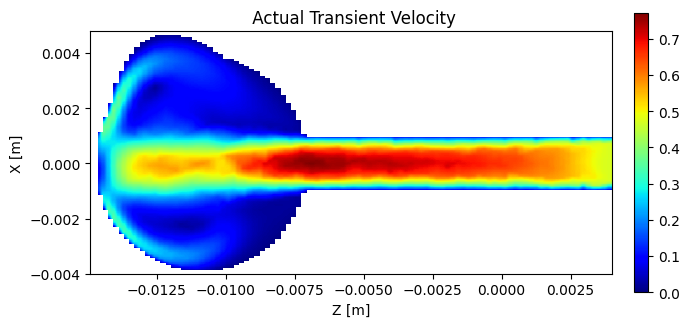

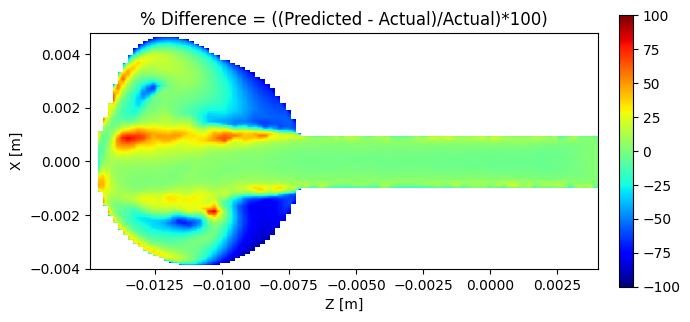

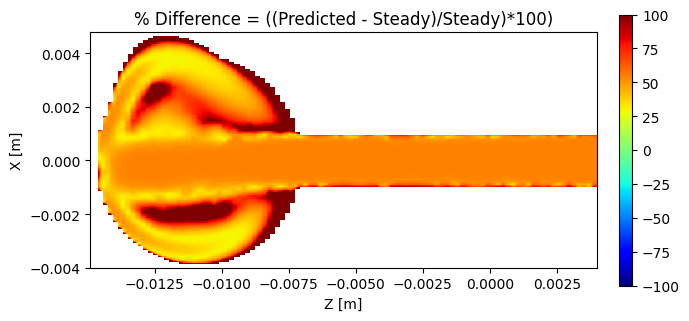

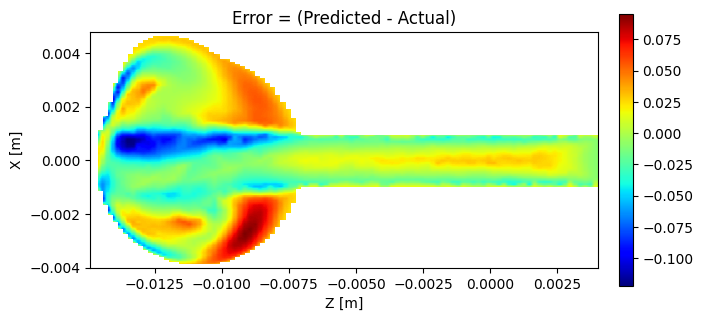

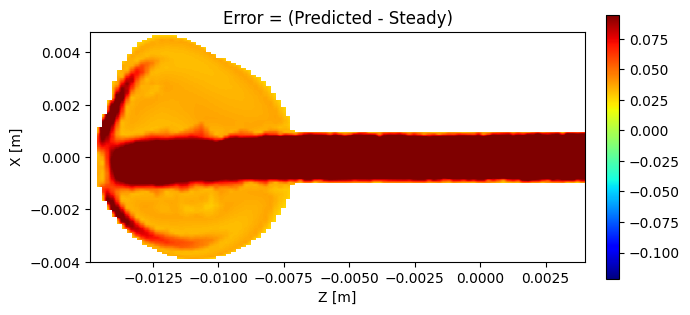

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1,fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2,fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Predicted - Actual)/Actual)*100)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Predicted - Steady)/Steady)*100)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, fraction=0.025, pad=0.04)
ax3.set_title('Error = (Predicted - Actual)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, fraction=0.025, pad=0.04)
ax4.set_title('Error = (Predicted - Steady)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

In [35]:
# Calculate the average absolute percentage changes
average_percentage_change3 = np.nanmean(np.abs(percentage_change3))
average_percentage_change4 = np.nanmean(np.abs(percentage_change4))

print(average_percentage_change3/100, 'and', average_percentage_change4/100)

# Extract maximum velocities
max_velocity = np.nanmax(PredictedTransient0 )  # Assuming Prediction0 is a NumPy array or pandas series
print(f"Maximum velocity from the prediction is: {max_velocity}")

max_velocity2 = CFDTransient0[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")

# Compute the relative error
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')


0.18743635497746772 and 0.6993212679759846
Maximum velocity from the prediction is: 4386.0
Maximum velocity from the actual is: 0.773
% is: 567299.7412677878


# **RESULTS N41**

In [37]:
PredictedTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41D.csv')
# Print column names
print(PredictedTransient1.columns)
PredictedTransient1 = PredictedTransient1.fillna(0)
PredictedTransient1 = PredictedTransient1.replace(' null', np.nan)
x = PredictedTransient1[' X [ m ]']
z = PredictedTransient1[' Z [ m ]']
ste_velocity1 = PredictedTransient1[' Velocity [ m s^-1 ]']
velocity1 = PredictedTransient1['Transient Prediction 1']
diff_ste1 = PredictedTransient1['Transient Prediction 1'] - PredictedTransient1[' Velocity [ m s^-1 ]']

CFDTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41Tmax\N41TV.csv')
print(CFDTransient1.columns)
CFDTransient1 = CFDTransient1.fillna(0)
CFDTransient1 = CFDTransient1.replace(' null', np.nan)
x = CFDTransient1 [' X [ m ]']
z = CFDTransient1 [' Z [ m ]']
velocity_truth1 = CFDTransient1 [' Velocity [ m s^-1 ]']
diff_vel1 = PredictedTransient1['Transient Prediction 1'] - CFDTransient1[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 1'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


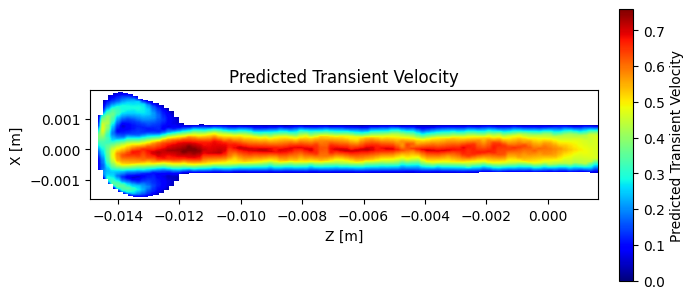

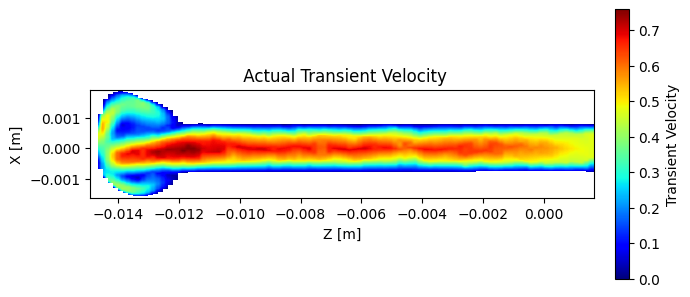

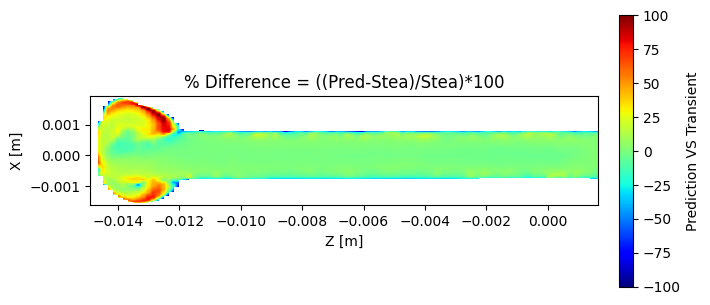

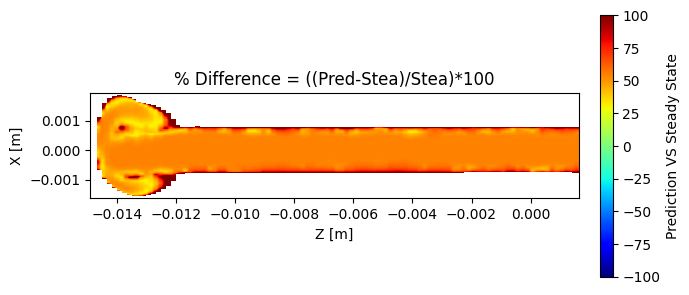

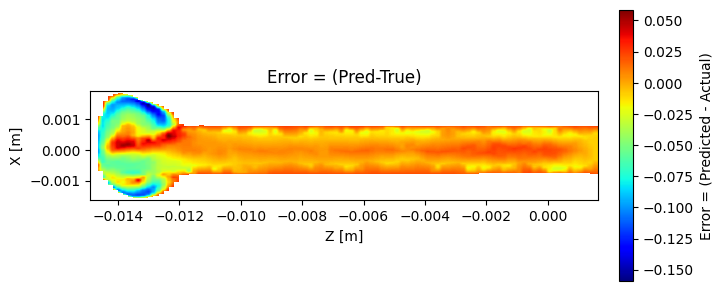

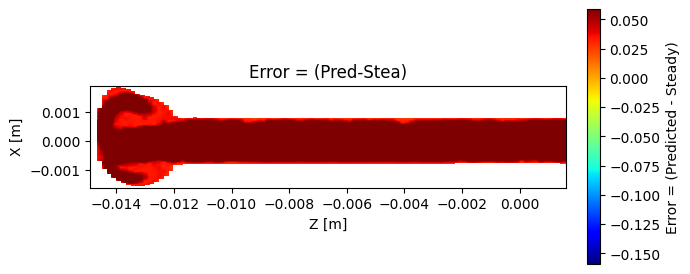

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity1, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity1, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth1, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel1, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste1, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()



In [36]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

print(average_percentage_change3, 'and', average_percentage_change4)

max_velocity = np.max(Prediction1)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient1[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")

relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient1[' Velocity [ m s^-1 ]'], Prediction1)
print(r2)

10.94105098338944 and 51.49739482809209
Maximum velocity from the prediction is: 0.7609114050865173
Maximum velocity from the actual is: 0.761
% is: 0.011641907159352928
0.9407200701588743


# **RESULTS N42**

In [44]:
PredictedTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42D.csv')
# Print column names
print(PredictedTransient2.columns)
PredictedTransient2 = PredictedTransient2.fillna(0)
PredictedTransient2 = PredictedTransient2.replace(' null', np.nan)
x = PredictedTransient2[' X [ m ]']
z = PredictedTransient2[' Z [ m ]']
ste_velocity2 = PredictedTransient2[' Velocity [ m s^-1 ]']
velocity2 = PredictedTransient2['Transient Prediction 2']
diff_ste2 = PredictedTransient2['Transient Prediction 2'] - PredictedTransient1[' Velocity [ m s^-1 ]']
CFDTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42Tmax\N42TV.csv')
print(CFDTransient2.columns)
CFDTransient2 = CFDTransient2.fillna(0)
CFDTransient2 = CFDTransient2.replace(' null', np.nan)
x = CFDTransient2 [' X [ m ]']
z = CFDTransient2 [' Z [ m ]']
velocity_truth2 = CFDTransient2 [' Velocity [ m s^-1 ]']
diff_vel2 = PredictedTransient2['Transient Prediction 2'] - CFDTransient2[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 2'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


In [1]:

grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity2, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity2, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth2, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel2, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste2, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values
# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


NameError: name 'np' is not defined

In [14]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

print(average_percentage_change3, 'and', average_percentage_change4)

max_velocity = np.max(Prediction2)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient2[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")

relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient2[' Velocity [ m s^-1 ]'], Prediction2)
print(r2)

18.365933473529545 and 50.13445776955963
Maximum velocity from the prediction is: 0.7894954085350037
Maximum velocity from the actual is: 0.774
% is: 2.001990766796336
0.9634687517047886


# **RESULTS N43**

In [46]:
PredictedTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43D.csv')
# Print column names
print(PredictedTransient3.columns)
PredictedTransient3 = PredictedTransient3.fillna(0)
PredictedTransient3 = PredictedTransient3.replace(' null', np.nan)
x = PredictedTransient3[' X [ m ]']
z = PredictedTransient3[' Z [ m ]']
ste_velocity3 = PredictedTransient3[' Velocity [ m s^-1 ]']
velocity3 = PredictedTransient3['Transient Prediction 3']
diff_ste3 = PredictedTransient3['Transient Prediction 3'] - PredictedTransient3[' Velocity [ m s^-1 ]']

CFDTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43Tmax\N43TV.csv')
print(CFDTransient3.columns)
CFDTransient3 = CFDTransient3.fillna(0)
CFDTransient3 = CFDTransient3.replace(' null', np.nan)
x = CFDTransient3 [' X [ m ]']
z = CFDTransient3 [' Z [ m ]']
velocity_truth3 = CFDTransient3 [' Velocity [ m s^-1 ]']
diff_vel3 = PredictedTransient3['Transient Prediction 3'] - CFDTransient3[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 3'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


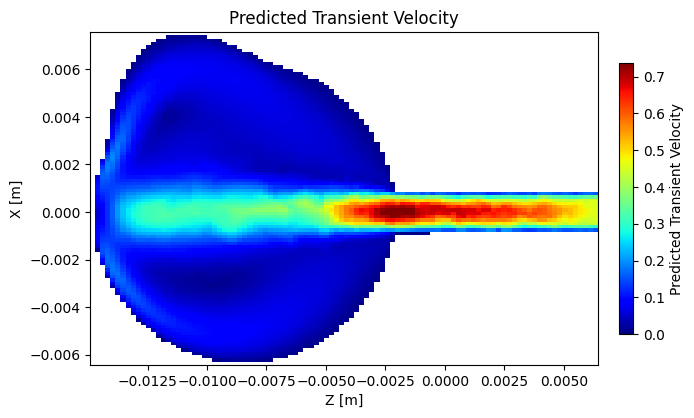

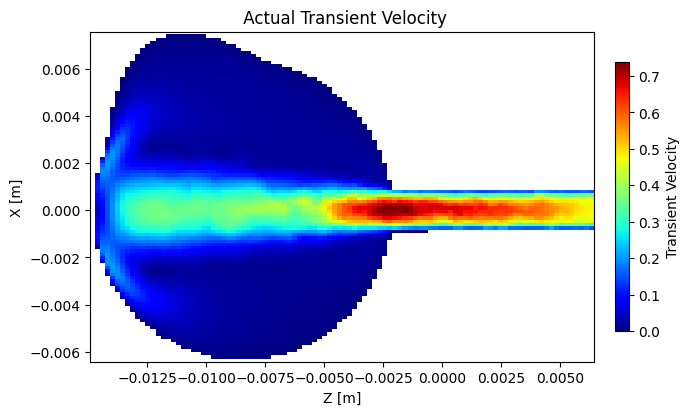

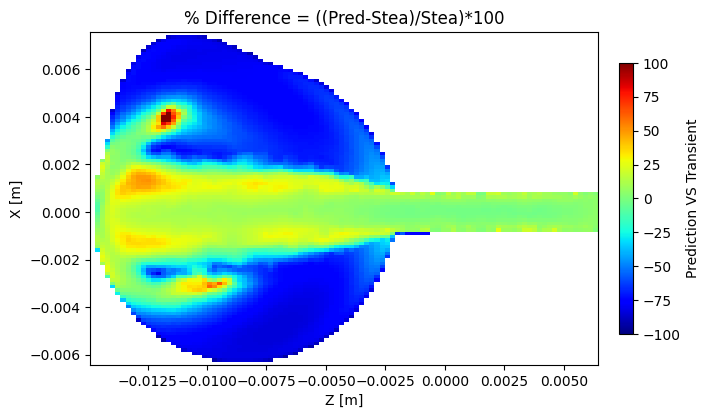

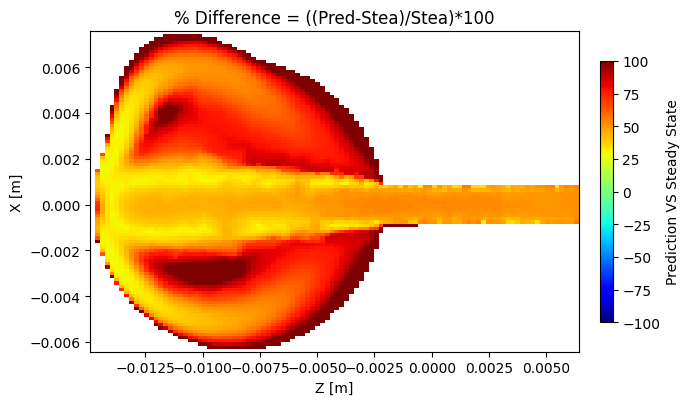

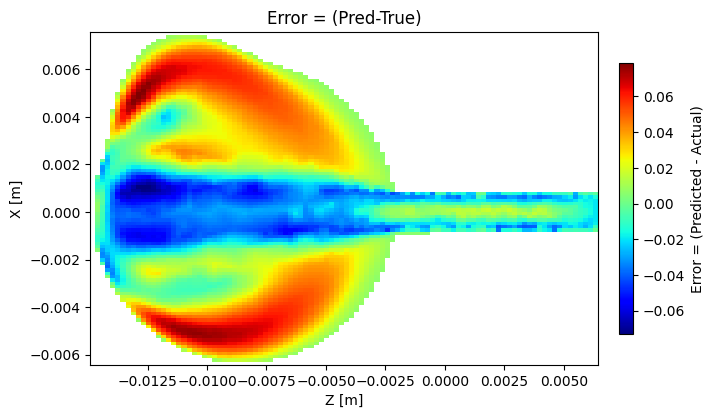

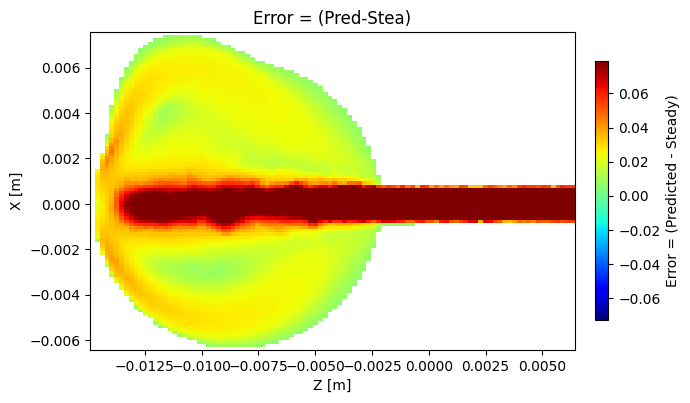

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity3, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity3, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth3, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel3, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste3, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()



In [48]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

print(average_percentage_change3, 'and', average_percentage_change4)

max_velocity = np.max(Prediction3)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity3 = CFDTransient3[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")

relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient3[' Velocity [ m s^-1 ]'], Prediction3)
print(r2)

41.31923466331224 and 67.49694455219071
Maximum velocity from the prediction is: 0.7548614144325256
Maximum velocity from the actual is: 0.773
% is: 2.346518184666803
0.9598696665026145


# **RESULTS N44**

In [49]:
PredictedTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44D.csv')
# Print column names
print(PredictedTransient4.columns)
PredictedTransient4 = PredictedTransient4.fillna(0)
PredictedTransient4 = PredictedTransient4.replace(' null', np.nan)
x = PredictedTransient4[' X [ m ]']
z = PredictedTransient4[' Z [ m ]']
ste_velocity4 = PredictedTransient4[' Velocity [ m s^-1 ]']
velocity4 = PredictedTransient4['Transient Prediction 4']
diff_ste4 = PredictedTransient4['Transient Prediction 4'] - PredictedTransient4[' Velocity [ m s^-1 ]']

CFDTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44Tmax\N44TV.csv')
print(CFDTransient4.columns)
CFDTransient4 = CFDTransient4.fillna(0)
CFDTransient4 = CFDTransient4.replace(' null', np.nan)
x = CFDTransient4 [' X [ m ]']
z = CFDTransient4 [' Z [ m ]']
velocity_truth4 = CFDTransient4 [' Velocity [ m s^-1 ]']
diff_vel4 = PredictedTransient4['Transient Prediction 4'] - CFDTransient4[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 4'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


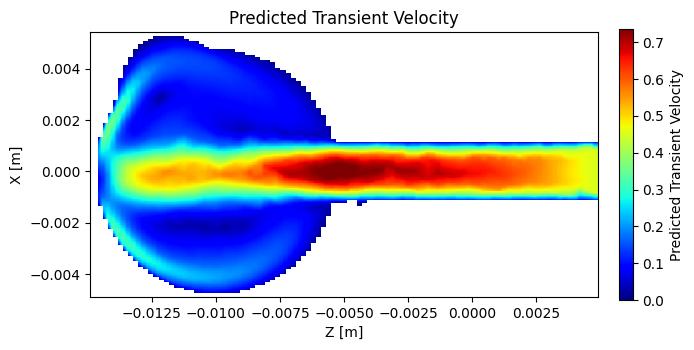

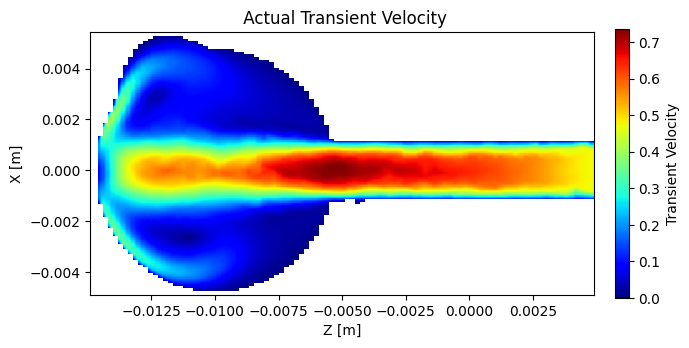

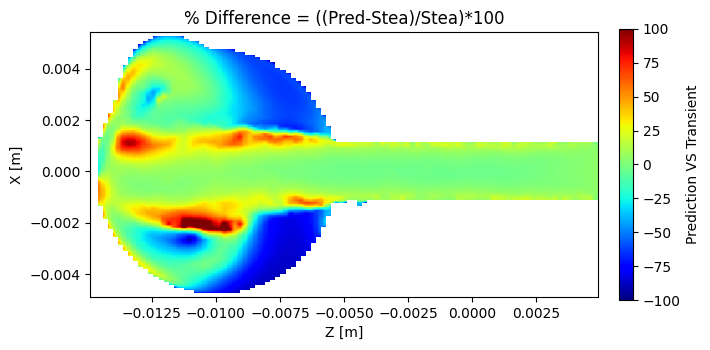

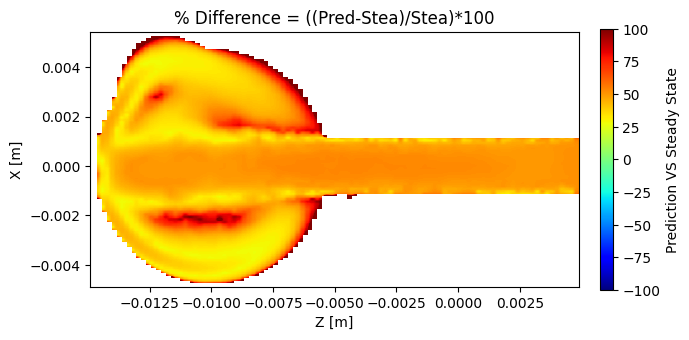

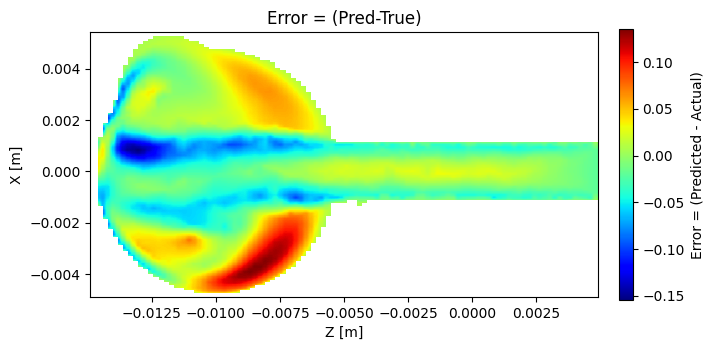

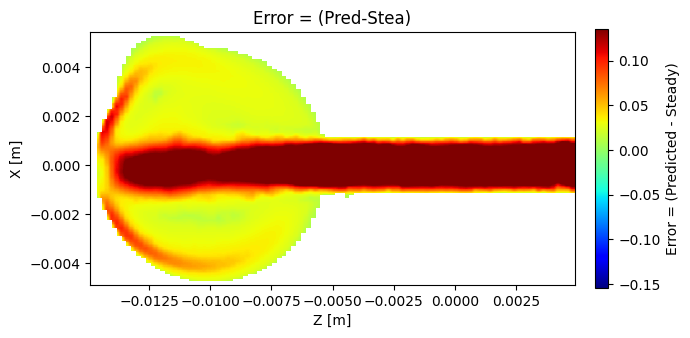

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity4, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity4, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth4, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel4, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste4, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


In [20]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

print(average_percentage_change3, 'and', average_percentage_change4)

max_velocity = np.max(Prediction4)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient4[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")

relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient4[' Velocity [ m s^-1 ]'], Prediction4)
print(r2)

24.9211283949147 and 51.70909475626648
Maximum velocity from the prediction is: 0.759398877620697
Maximum velocity from the actual is: 0.737
% is: 3.039196420718729
0.9497672532965247


# **RESULTS N45**

In [51]:
PredictedTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45D.csv')
# Print column names
print(PredictedTransient5.columns)
PredictedTransient5 = PredictedTransient5.fillna(0)
PredictedTransient5 = PredictedTransient5.replace(' null', np.nan)
x = PredictedTransient5[' X [ m ]']
z = PredictedTransient5[' Z [ m ]']
ste_velocity5 = PredictedTransient5[' Velocity [ m s^-1 ]']
velocity5 = PredictedTransient5['Transient Prediction 5']
diff_ste5 = PredictedTransient5['Transient Prediction 5'] - PredictedTransient5[' Velocity [ m s^-1 ]']

CFDTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45Tmax\N45TV.csv')
print(CFDTransient5.columns)
CFDTransient5 = CFDTransient5.fillna(0)
CFDTransient5 = CFDTransient5.replace(' null', np.nan)
x = CFDTransient5 [' X [ m ]']
z = CFDTransient5 [' Z [ m ]']
velocity_truth5 = CFDTransient5 [' Velocity [ m s^-1 ]']
diff_vel5 = PredictedTransient5['Transient Prediction 5'] - CFDTransient5[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 5'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


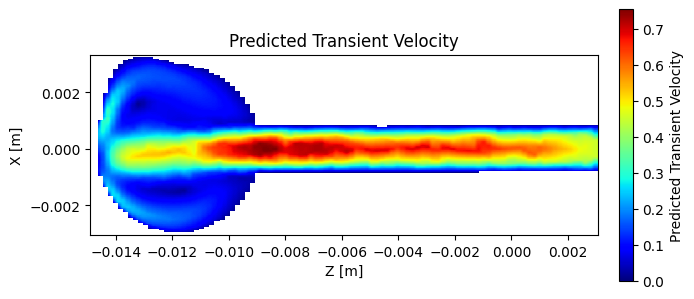

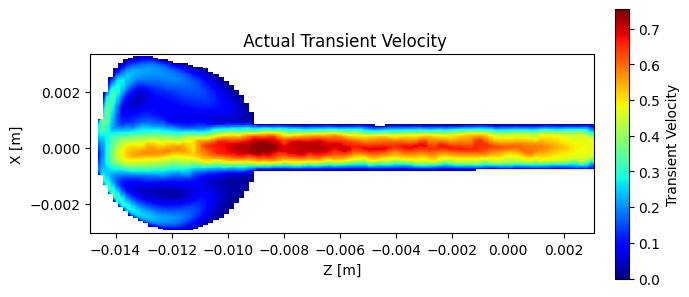

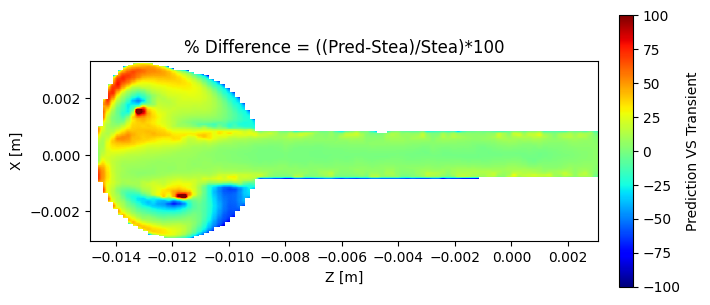

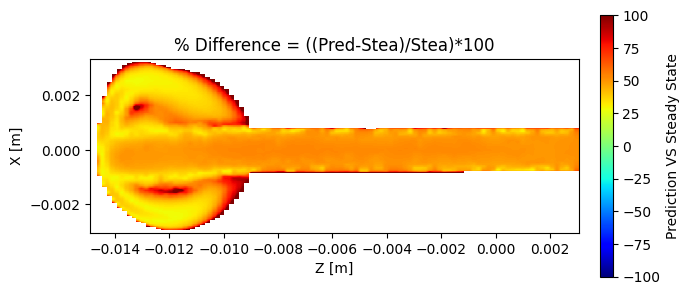

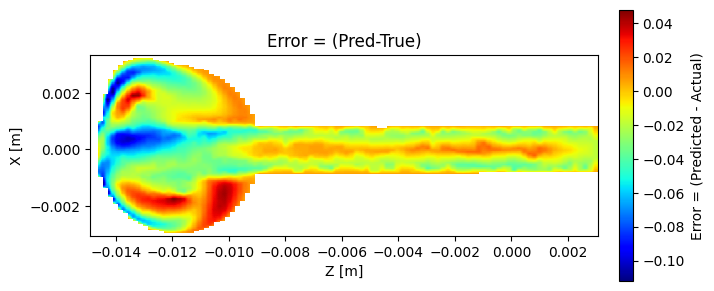

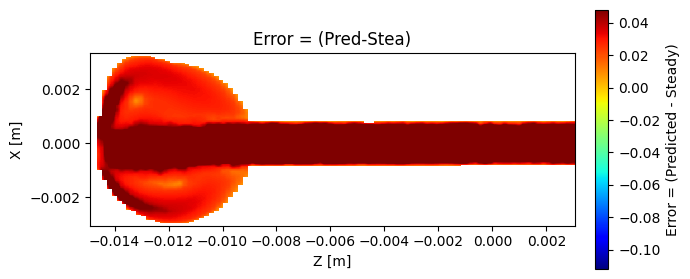

15.723935507935646 and 52.916176234331765
Maximum velocity from the prediction is: 0.7654606699943542
Maximum velocity from the actual is: 0.759
% is: 0.8512081678991094
0.9732726131509246


In [52]:

# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity5, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity5, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth5, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel5, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste5, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values
# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))
print(average_percentage_change3, 'and', average_percentage_change4)
max_velocity = np.max(Prediction5)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient5[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient5[' Velocity [ m s^-1 ]'], Prediction5)
print(r2)

# **RESULTS N46**

In [53]:
PredictedTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46D.csv')
# Print column names
print(PredictedTransient6.columns)
PredictedTransient6 = PredictedTransient6.fillna(0)
PredictedTransient6 = PredictedTransient6.replace(' null', np.nan)
x = PredictedTransient6[' X [ m ]']
z = PredictedTransient6[' Z [ m ]']
ste_velocity6 = PredictedTransient6[' Velocity [ m s^-1 ]']
velocity6 = PredictedTransient6['Transient Prediction 6']
diff_ste6 = PredictedTransient6['Transient Prediction 6'] - PredictedTransient6[' Velocity [ m s^-1 ]']

CFDTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46Tmax\N46TV.csv')
print(CFDTransient6.columns)
CFDTransient6 = CFDTransient6.fillna(0)
CFDTransient6 = CFDTransient6.replace(' null', np.nan)
x = CFDTransient6 [' X [ m ]']
z = CFDTransient6 [' Z [ m ]']
velocity_truth6 = CFDTransient6 [' Velocity [ m s^-1 ]']
diff_vel6 = PredictedTransient6 ['Transient Prediction 6'] - CFDTransient6[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 6'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


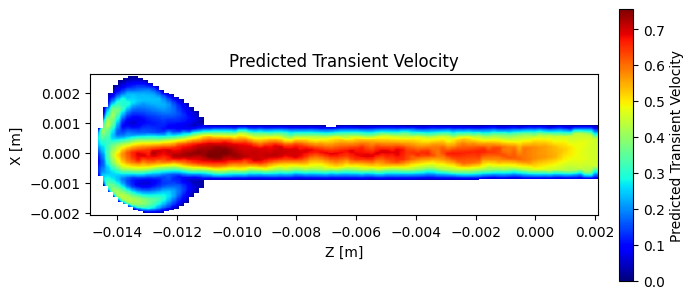

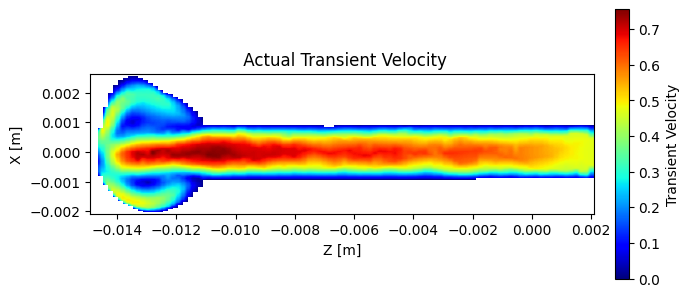

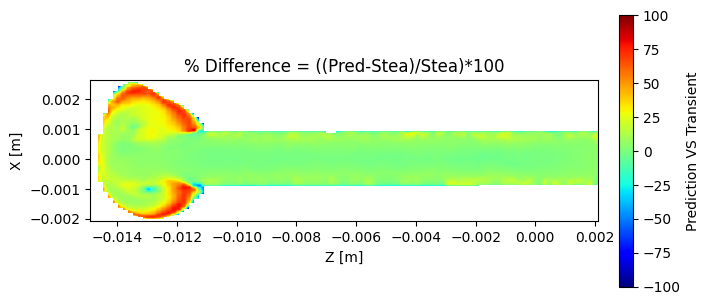

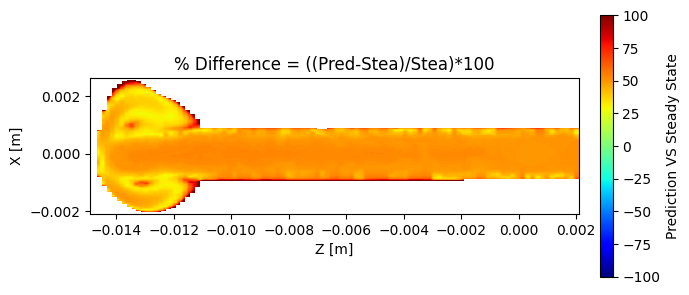

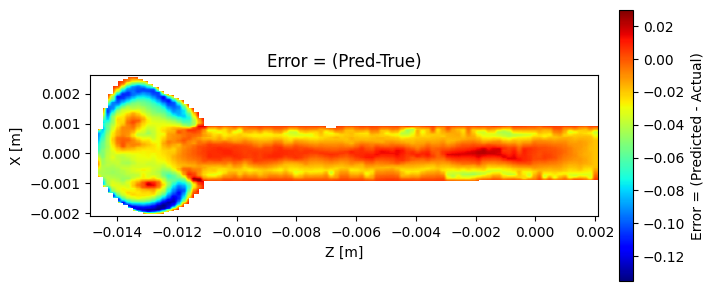

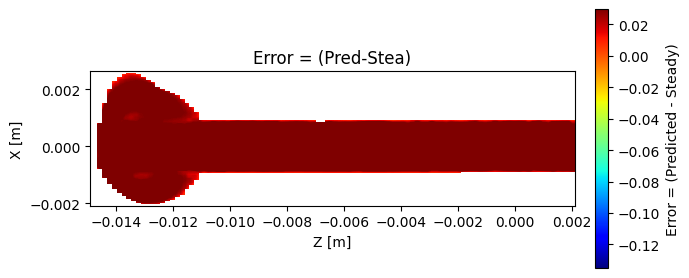

11.642277788130816 and 52.774192992732566
Maximum velocity from the prediction is: 0.7654606699943542
Maximum velocity from the actual is: 0.761
% is: 0.5861590005721732
0.953705238902949


In [54]:

# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity6, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity6, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth6, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel6, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste6, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))
print(average_percentage_change3, 'and', average_percentage_change4)
max_velocity = np.max(Prediction6)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient6[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient6[' Velocity [ m s^-1 ]'], Prediction6)
print(r2)

# **RESULTS N47**

In [55]:
PredictedTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47D.csv')
# Print column names
print(PredictedTransient7.columns)
PredictedTransient7 = PredictedTransient7.fillna(0)
PredictedTransient7 = PredictedTransient7.replace(' null', np.nan)
x = PredictedTransient7[' X [ m ]']
z = PredictedTransient7[' Z [ m ]']
ste_velocity7 = PredictedTransient7[' Velocity [ m s^-1 ]']
velocity7 = PredictedTransient7['Transient Prediction 7']
diff_ste7 = PredictedTransient7['Transient Prediction 7'] - PredictedTransient7[' Velocity [ m s^-1 ]']

CFDTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47Tmax\N47TV.csv')
print(CFDTransient7.columns)
CFDTransient7 = CFDTransient7.fillna(0)
CFDTransient7 = CFDTransient7.replace(' null', np.nan)
x = CFDTransient7 [' X [ m ]']
z = CFDTransient7 [' Z [ m ]']
velocity_truth7 = CFDTransient7 [' Velocity [ m s^-1 ]']
diff_vel7 = PredictedTransient7 ['Transient Prediction 7'] - CFDTransient7[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 7'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


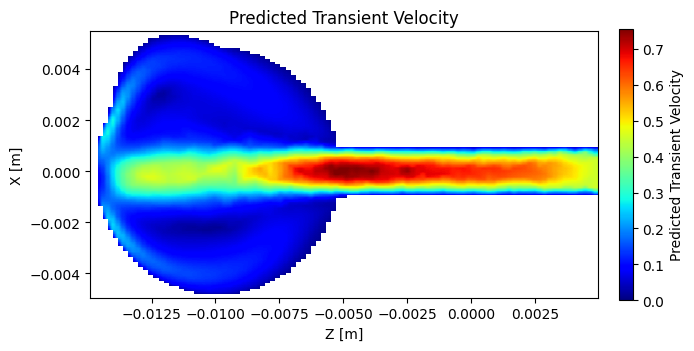

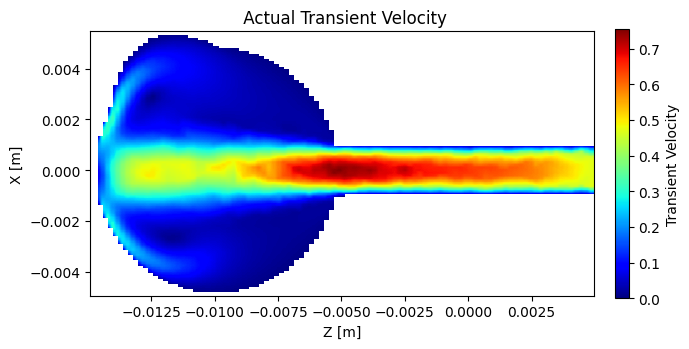

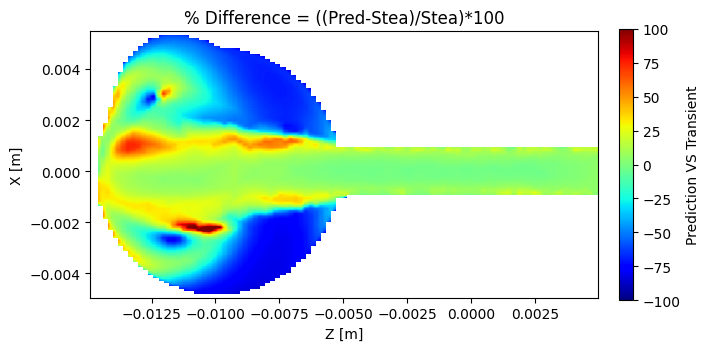

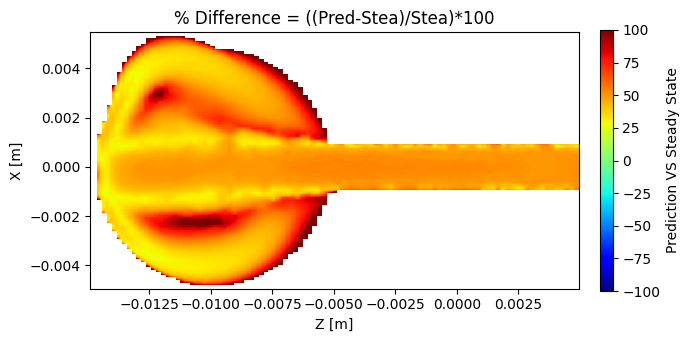

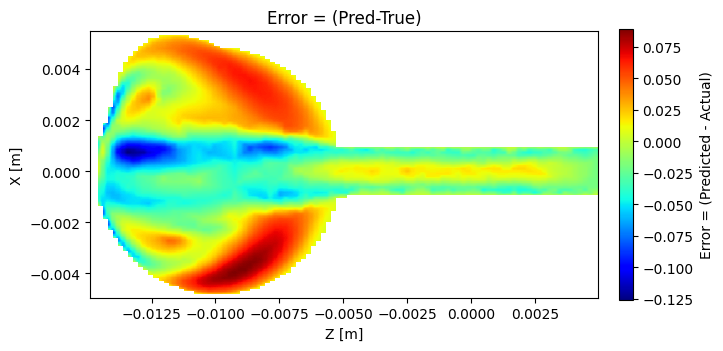

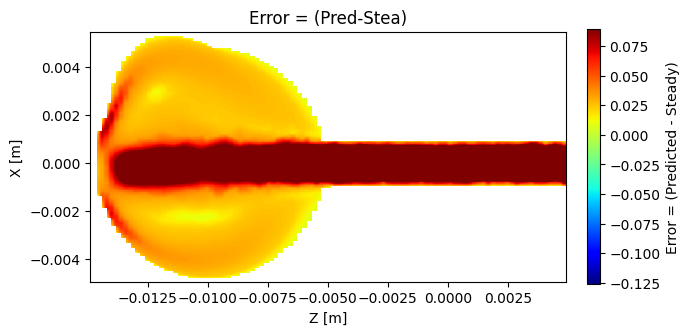

28.51655307743463 and 53.990613521984756
Maximum velocity from the prediction is: 0.7731295824050903
Maximum velocity from the actual is: 0.757
% is: 2.130724227885116
0.9612845939373993


In [56]:

# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity7, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity7, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth7, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel7, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste7, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))
print(average_percentage_change3, 'and', average_percentage_change4)
max_velocity = np.max(Prediction7)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient7[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient7[' Velocity [ m s^-1 ]'], Prediction7)
print(r2)

# **RESULTS N48**

In [57]:
PredictedTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48D.csv')
# Print column names
print(PredictedTransient8.columns)
PredictedTransient8 = PredictedTransient8.fillna(0)
PredictedTransient8 = PredictedTransient8.replace(' null', np.nan)
x = PredictedTransient8[' X [ m ]']
z = PredictedTransient8[' Z [ m ]']
ste_velocity8 = PredictedTransient8[' Velocity [ m s^-1 ]']
velocity8 = PredictedTransient8['Transient Prediction 8']
diff_ste8 = PredictedTransient8['Transient Prediction 8'] - PredictedTransient8[' Velocity [ m s^-1 ]']

CFDTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48Tmax\N48TV.csv')
print(CFDTransient8.columns)
CFDTransient8 = CFDTransient8.fillna(0)
CFDTransient8 = CFDTransient8.replace(' null', np.nan)
x = CFDTransient8 [' X [ m ]']
z = CFDTransient8 [' Z [ m ]']
velocity_truth8 = CFDTransient8 [' Velocity [ m s^-1 ]']
diff_vel8 = PredictedTransient8 ['Transient Prediction 8'] - CFDTransient8[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 8'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


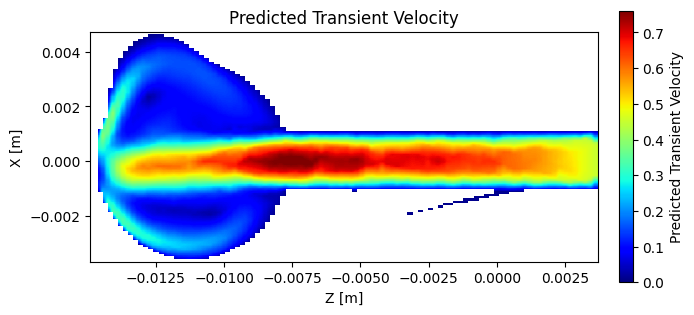

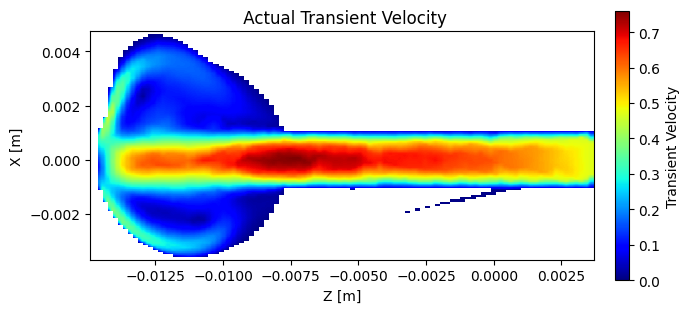

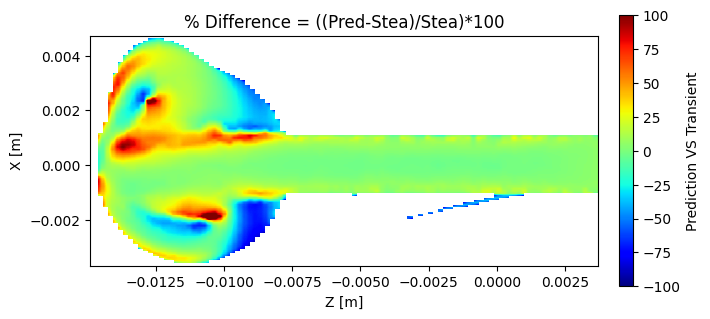

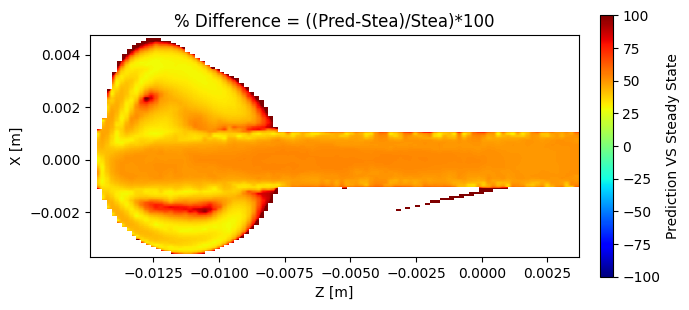

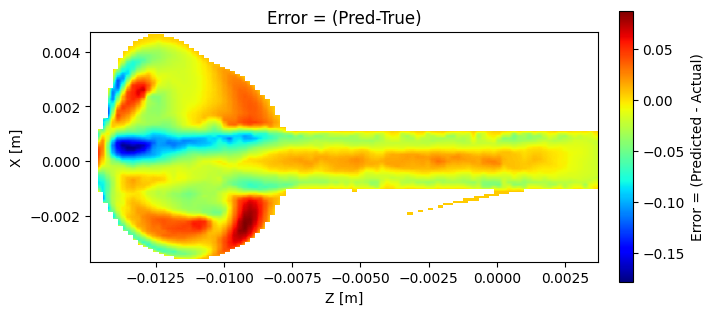

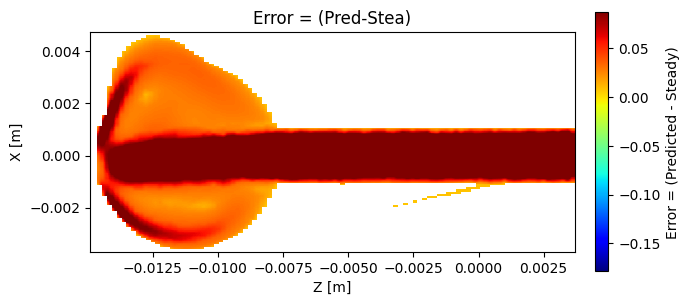

18.00776340271425 and 54.2933259696477
Maximum velocity from the prediction is: 0.7807379961013794
Maximum velocity from the actual is: 0.763
% is: 2.3247701312423827
0.9658029919891428


In [58]:

# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity8, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity8, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth8, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel8, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste8, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))
print(average_percentage_change3, 'and', average_percentage_change4)
max_velocity = np.max(Prediction8)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient8[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient8[' Velocity [ m s^-1 ]'], Prediction8)
print(r2)

# **RESULTS N49**

In [59]:
PredictedTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49D.csv')
# Print column names
print(PredictedTransient9.columns)
PredictedTransient9 = PredictedTransient9.fillna(0)
PredictedTransient9 = PredictedTransient9.replace(' null', np.nan)
x = PredictedTransient9[' X [ m ]']
z = PredictedTransient9[' Z [ m ]']
ste_velocity9 = PredictedTransient9[' Velocity [ m s^-1 ]']
velocity9 = PredictedTransient9['Transient Prediction 9']
diff_ste9 = PredictedTransient9['Transient Prediction 9'] - PredictedTransient9[' Velocity [ m s^-1 ]']

CFDTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49Tmax\N49TV.csv')
print(CFDTransient9.columns)
CFDTransient9 = CFDTransient9.fillna(0)
CFDTransient9 = CFDTransient9.replace(' null', np.nan)
x = CFDTransient9 [' X [ m ]']
z = CFDTransient9 [' Z [ m ]']
velocity_truth9 = CFDTransient9 [' Velocity [ m s^-1 ]']
diff_vel9 = PredictedTransient9 ['Transient Prediction 9'] - CFDTransient9[' Velocity [ m s^-1 ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]', 'Transient Prediction 9'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Velocity [ m s^-1 ]'],
      dtype='object')


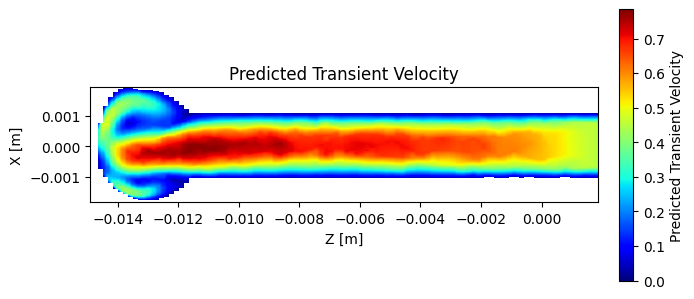

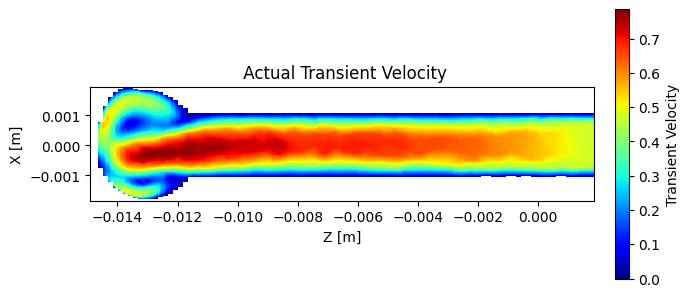

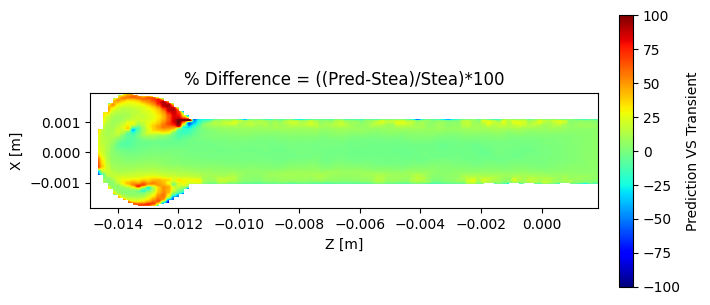

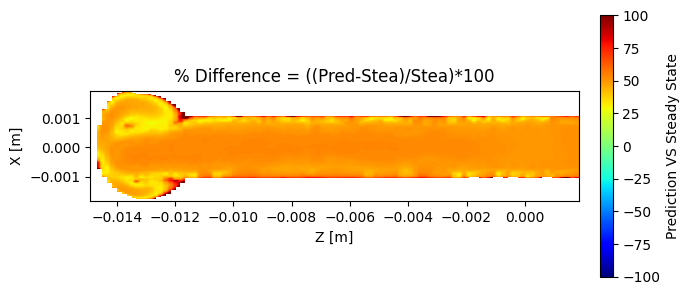

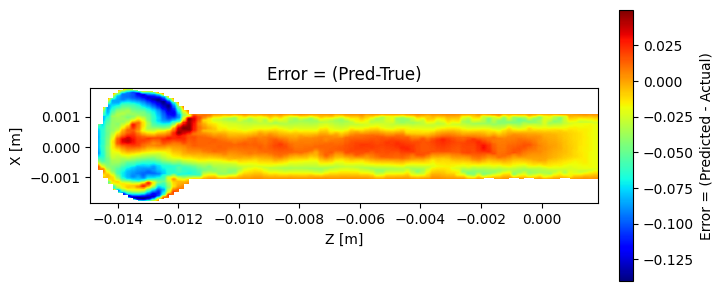

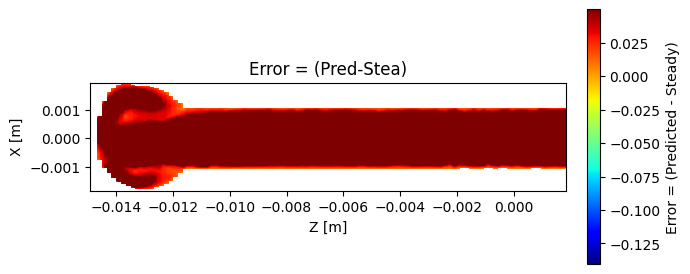

9.45843725200924 and 50.42389519653209
Maximum velocity from the prediction is: 0.7792662382125854
Maximum velocity from the actual is: 0.789
% is: 1.2336833697610374
0.9596014350421956


In [60]:

# Generate your grid
grid_x, grid_z = np.mgrid[min(x):max(x):100j, min(z):max(z):100j]

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, z), ste_velocity9, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, z), velocity9, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, z), velocity_truth9, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, z), diff_vel9, (grid_x, grid_z), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, z), diff_ste9, (grid_x, grid_z), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Create a masked array where 'nan' values, 0 velocity values, and velocity values 0.05 or less are masked
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities by 90 degrees and transpose
rotated_masked_velocity0 = np.transpose(np.rot90(masked_velocity0, 1))
rotated_masked_velocity1 = np.transpose(np.rot90(masked_velocity1, 1))
rotated_masked_velocity2 = np.transpose(np.rot90(masked_velocity2, 1))
rotated_masked_velocity3 = np.transpose(np.rot90(masked_velocity3, 1))
rotated_masked_velocity4 = np.transpose(np.rot90(masked_velocity4, 1))

# Generate heat maps for velocity
fig, (ax1) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im1 = ax1.imshow(rotated_masked_velocity1, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.025, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("Z [m]")
ax1.set_ylabel("X [m]")

# Generate heat maps for velocity
fig, (ax2) = plt.subplots(1, figsize=(7, 7))  # Adjusted figsize for 1x2 subplots
fig.patch.set_facecolor('white')

im2 = ax2.imshow(rotated_masked_velocity2, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.025, pad=0.04)
ax2.set_title(' Actual Transient Velocity')
ax2.set_xlabel("Z [m]")
ax2.set_ylabel("X [m]")

plt.tight_layout()
plt.show()

# Calculate percentage differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100



fig, (ax3) = plt.subplots(1, figsize=(7, 7))
im3 = ax3.imshow(percentage_change3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='Prediction VS Transient', fraction=0.025, pad=0.04)
ax3.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")


fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(percentage_change4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='Prediction VS Steady State', fraction=0.025, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


# Plotting
fig, (ax3) = plt.subplots(1, figsize=(7, 7))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(rotated_masked_velocity3, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im3, ax=ax3, label='Error = (Predicted - Actual)', fraction=0.025, pad=0.04)
ax3.set_title('Error = (Pred-True)')
ax3.set_xlabel("Z [m]")
ax3.set_ylabel("X [m]")

fig, (ax4) = plt.subplots(1, figsize=(7, 7))
im4 = ax4.imshow(rotated_masked_velocity4, extent=(min(z), max(z), min(x), max(x)), origin='lower', cmap=cmap, vmin=rotated_masked_velocity3.min(), vmax=rotated_masked_velocity3.max())
fig.colorbar(im4, ax=ax4, label='Error = (Predicted - Steady)', fraction=0.025, pad=0.04)
ax4.set_title('Error = (Pred-Stea)')
ax4.set_xlabel("Z [m]")
ax4.set_ylabel("X [m]")

plt.tight_layout()
plt.show()


average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))
print(average_percentage_change3, 'and', average_percentage_change4)
max_velocity = np.max(Prediction9)
print(f"Maximum velocity from the prediction is: {max_velocity}")
max_velocity2 = CFDTransient9[' Velocity [ m s^-1 ]'].max()
print(f"Maximum velocity from the actual is: {max_velocity2}")
relative_error = abs(max_velocity - max_velocity2) / abs(max_velocity2)
relative_error_percentage = relative_error * 100  # Convert to percentage
print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score(CFDTransient9[' Velocity [ m s^-1 ]'], Prediction9)
print(r2)